In [1]:
import torch
from torch import nn

import torchvision
# To use pytorch's built-in datasets
from torchvision import datasets
# To transform PIL image to tensor
from torchvision import transforms

import matplotlib.pyplot as plt

## Getting a dataset

In [2]:
train_data = datasets.FashionMNIST(train=True, root='data', download=True, transform=transforms.ToTensor(),
                                   target_transform=None)

In [3]:
test_data = datasets.FashionMNIST(train=False, root='data', download=True, transform=transforms.ToTensor(),
                                  target_transform=None)

In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### Checking the input and output shapes of data

In [5]:
class_to_idx = train_data.class_to_idx
class_names = train_data.classes

In [6]:
print(f"Shape of the image: {image.shape} -> [color channels, height, width]")

Shape of the image: torch.Size([1, 28, 28]) -> [color channels, height, width]


### Visualising our image

(-0.5, 27.5, 27.5, -0.5)

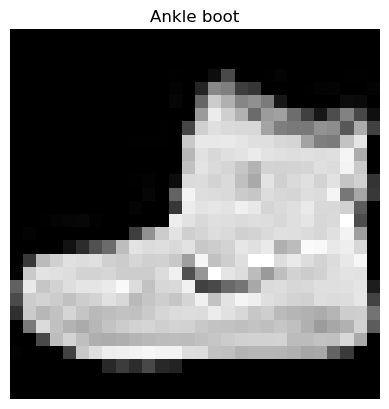

In [7]:
image, label = train_data[0]
# Matplotlib expects the image in the format (h,w,c) and as for gray scale it doesn't expect color channel
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

## Prepare Dataloader

Turns our dataset into python iterable

More specifically, we want to turn our data into mini-batches.

We do this:
1. Computationally Efficient
2. Gives our neural network to update its gradients per epoch 

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x24d3ff22d90>,
 <torch.utils.data.dataloader.DataLoader at 0x24d3fed1990>)

In [9]:
print(
    f"Length of train : {len(train_dataloader)} batches of 32 | Length of test : {len(test_dataloader)} batches of 32")

Length of train : 1875 batches of 32 | Length of test : 313 batches of 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

(-0.5, 27.5, 27.5, -0.5)

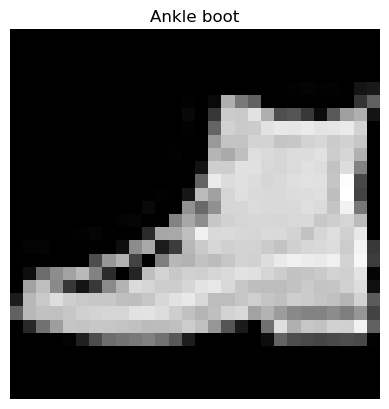

In [11]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

## Build a baseline model (improve upon experimentation)

In [12]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening : {x.shape} -> [c,h,w]")
print(f"Shape after flattening : {output.shape} -> [c,h*w]")

Shape before flattening : torch.Size([1, 28, 28]) -> [c,h,w]
Shape after flattening : torch.Size([1, 784]) -> [c,h*w]


In [13]:
class FashionMNISTV0(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int
                ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )

    def forward(self,x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTV0(
    input_shape=784, # this is 28*28,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0.to('cpu')

model_0

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Setup loss function and optimizer

In [15]:
from helper_functions import accuracy_fn

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.1)

### Creating a function to time our experiments

In [17]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None
                    ):
    total_time = end-start
    print(f"Train time on {device} : {total_time:.3f} seconds")
    return total_time

In [18]:
'''start_timer = timer()
end_timer = timer()

print_train_time(start_timer,end_timer,device='gpu')
'''

"start_timer = timer()\nend_timer = timer()\n\nprint_train_time(start_timer,end_timer,device='gpu')\n"

### Creating a training and testing loop

In [19]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    train_loss = 0

    # Loop through training data
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()

        # 1. Forward Pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss+=loss

        optimizer.zero_grad()

        # 3. Loss backward
        loss.backward()

        # 4. optimizer step
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    # Testing
    test_loss,test_acc = 0,0
    model_0.eval()

    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_pred = model_0(X_test)
            
            test_loss+=loss_fn(test_pred,y_test)

            test_acc+=accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))

        test_loss/=len(test_dataloader)

        test_acc/=len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu : 20.665 seconds


## Model Evaluation

In [24]:
device = "cpu"

In [25]:
torch.manual_seed(42)

def eval_model(model:torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
               device:torch.device = device
              ):
    """ Returns a dictionary of model results"""
    loss,acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate loss per batch
            loss+= loss_fn(y_pred,y)
            acc+= accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        loss/=len(data_loader)
        acc/=len(data_loader)

    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc,
           }

In [26]:
model_0_results = eval_model(model_0,test_dataloader,loss_fn,accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Setup device agnostic code

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
class FashionMNISTV1(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int
                ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )

    def forward(self,x):
        return self.layer_stack(x)

In [30]:
torch.manual_seed(42)

model_1 = FashionMNISTV1(input_shape=784,hidden_units=10,output_shape=len(class_names)).to(device)

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [33]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [34]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epochs:{epoch}--------------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs:0--------------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epochs:1--------------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epochs:2--------------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda : 39.506 seconds


In [38]:
model_1_results = eval_model(accuracy_fn=accuracy_fn,data_loader=test_dataloader,model=model_1,loss_fn=loss_fn,device="cuda")
model_1_results

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

## Building a CNN

In [91]:
device = 'cpu'

In [92]:
class FashionMNISTV2(nn.Module):
    # input_shape for cnn is the no of color channels
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()

        # The first two blocks will learn/study features from the images
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [93]:
torch.manual_seed(42)

model_2 = FashionMNISTV2(input_shape=1,output_shape=len(class_names),hidden_units=10)

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.1)

In [95]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device='cpu'
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device='cpu'
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device='cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.60070 | Train accuracy: 78.25%
Test loss: 0.38804 | Test accuracy: 86.33%

Epoch: 1
---------
Train loss: 0.35925 | Train accuracy: 86.99%
Test loss: 0.34650 | Test accuracy: 87.39%

Epoch: 2
---------
Train loss: 0.31927 | Train accuracy: 88.38%
Test loss: 0.31140 | Test accuracy: 89.13%

Train time on cpu : 80.992 seconds


In [96]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.31139636039733887,
 'model_acc': 89.12739616613419}

In [98]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTV0,0.476639,83.426518,20.665286
1,FashionMNISTV1,0.685001,75.019968,39.505747
2,FashionMNISTV2,0.311396,89.127396,80.992209


## Make and evaluate random predictions with best model 

In [99]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device to include to batch size

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [112]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 9 (Ankle boot)


In [113]:
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 7, 2, 0, 1, 0, 3, 5, 4])

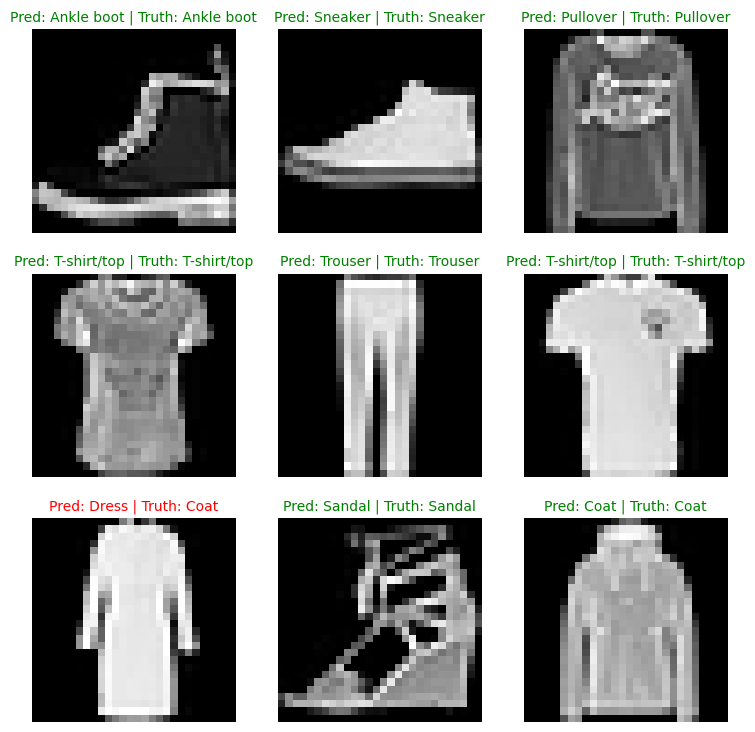

In [114]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);